# Welcome  

Notebook Author: Samuel Alter  
Notebook Subject: Capstone Project - Geographic Analysis

BrainStation Winter 2023: Data Science

## Introduction

This notebook walks through an analysis of geographic data (i.e., elevation and aspect) - looking at its influence on wildfire incidence. We want to see if these features of the landscape can accurately predict when a wildfire will be more likely. The location of study for this project are the Santa Monica Mountains, an east-west trending mountain range.

The dataset consists of a high-density grid that have elevation, and aspect data appended to each point. Also added to each point is whether there was a wildfire in that location. The elevation and aspect data are sourced from [USGS EarthExplorer](https://earthexplorer.usgs.gov), using the SRTM dataset. The wildfire data is sourced from the [National Interagency Fire Center](https://data-nifc.opendata.arcgis.com/datasets/nifc::interagencyfireperimeterhistory-all-years-view/explore?location=39.778749%2C-121.769073%2C11.96). 

Please refer to the visualization notebook to see maps of the field site.

## Initial Setup

### Imports

In [215]:
import pandas as pd
import numpy as np
import seaborn as sns

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [216]:
# import geographic information .CSV

sm_geo_original=pd.read_csv('/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/shapefiles/joins/sm_geo_combine.csv')
sm_geo_original

,objectid,perim_id,perim_elevation_1,perim_asp_1,fire,geometry
0,4751.0,1644.0,434.0,31.883564,1,MULTIPOLYGON (((-118.297645979672 34.135057069...
1,4751.0,1645.0,349.0,7.624194,1,MULTIPOLYGON (((-118.297645979672 34.135057069...
2,4751.0,1646.0,288.0,72.613029,1,MULTIPOLYGON (((-118.297645979672 34.135057069...
3,4751.0,1647.0,189.0,335.170654,1,MULTIPOLYGON (((-118.297645979672 34.135057069...
4,4751.0,1648.0,229.0,346.464142,1,MULTIPOLYGON (((-118.297645979672 34.135057069...
...,...,...,...,...,...,...
19140,0.0,5935.0,52.0,149.036240,0,POINT (-118.2930000000007 34)
19141,0.0,5936.0,51.0,185.194427,0,POINT (-118.2880000000007 34)
19142,0.0,5937.0,52.0,270.000000,0,POINT (-118.2830000000007 34)
19143,0.0,5938.0,54.0,341.565063,0,POINT (-118.2780000000007 34)


### EDA

In [217]:
sm_geo_original.isna().sum()

objectid               0
perim_id             641
perim_elevation_1    641
perim_asp_1          668
fire                   0
geometry               0
dtype: int64

In [218]:
sm_geo_original[sm_geo_original['perim_asp_1'].isna()==True]

,objectid,perim_id,perim_elevation_1,perim_asp_1,fire,geometry
14,4753.0,NaN,NaN,NaN,1,MULTIPOLYGON (((-118.305363835672 34.119507991...
15,4767.0,NaN,NaN,NaN,1,MULTIPOLYGON (((-118.843533279074 34.169495387...
24,4796.0,NaN,NaN,NaN,1,MULTIPOLYGON (((-118.60574361788 34.1457095562...
25,4849.0,NaN,NaN,NaN,1,MULTIPOLYGON (((-118.377669263434 34.122895200...
26,4850.0,NaN,NaN,NaN,1,MULTIPOLYGON (((-118.574062124596 34.079625547...
...,...,...,...,...,...,...
18743,0.0,4600.0,32.0,NaN,0,POINT (-118.3680000000007 34.04)
18786,0.0,4752.0,53.0,NaN,0,POINT (-118.4330000000006 34.035)
18810,0.0,4776.0,67.0,NaN,0,POINT (-118.3130000000007 34.035)
18863,0.0,4941.0,52.0,NaN,0,POINT (-118.3130000000007 34.03)


In [219]:
(sm_geo_original.isna().sum())/(sm_geo_original.count())*100

objectid             0.000000
perim_id             3.464116
perim_elevation_1    3.464116
perim_asp_1          3.615306
fire                 0.000000
geometry             0.000000
dtype: float64

I have enough data that $3.5{\%}$ (roughly $650$ rows) is not a large portion of the dataset. I will remove these `NaN` rows:

In [220]:
sm_geo_original=sm_geo_original.dropna()
sm_geo_original.isna().sum()

objectid             0
perim_id             0
perim_elevation_1    0
perim_asp_1          0
fire                 0
geometry             0
dtype: int64

Convert aspect, which is a continuous variable, into a categorical.

First, rename columns.

In [221]:
# rename columns
sm_geo=sm_geo_original.copy()

sm_geo['asp_cont']=sm_geo['perim_asp_1']

sm_geo=sm_geo.drop(columns=(['perim_asp_1']))

sm_geo['elevation']=sm_geo['perim_elevation_1']

sm_geo=sm_geo.drop(columns=(['perim_elevation_1']))

sm_geo

,objectid,perim_id,fire,geometry,asp_cont,elevation
0,4751.0,1644.0,1,MULTIPOLYGON (((-118.297645979672 34.135057069...,31.883564,434.0
1,4751.0,1645.0,1,MULTIPOLYGON (((-118.297645979672 34.135057069...,7.624194,349.0
2,4751.0,1646.0,1,MULTIPOLYGON (((-118.297645979672 34.135057069...,72.613029,288.0
3,4751.0,1647.0,1,MULTIPOLYGON (((-118.297645979672 34.135057069...,335.170654,189.0
4,4751.0,1648.0,1,MULTIPOLYGON (((-118.297645979672 34.135057069...,346.464142,229.0
...,...,...,...,...,...,...
19140,0.0,5935.0,0,POINT (-118.2930000000007 34),149.036240,52.0
19141,0.0,5936.0,0,POINT (-118.2880000000007 34),185.194427,51.0
19142,0.0,5937.0,0,POINT (-118.2830000000007 34),270.000000,52.0
19143,0.0,5938.0,0,POINT (-118.2780000000007 34),341.565063,54.0


In [222]:
def degToCompass(num):
    '''
    From https://stackoverflow.com/questions/\
    7490660/converting-wind-direction-in-angles-to-text-words
    
    Takes a value between 0 and 360 and 
    outputs the corresponding compass representation
    '''
    val=int((num/22.5)+.5)
    arr=["N","NNE","NE","ENE","E","ESE", "SE", "SSE","S","SSW","SW","WSW","W","WNW","NW","NNW"]
    return arr[(val % 16)]

degToCompass(355)

'N'

In [223]:
sm_geo['asp_cont']

0         31.883564
1          7.624194
2         72.613029
3        335.170654
4        346.464142
            ...    
19140    149.036240
19141    185.194427
19142    270.000000
19143    341.565063
19144    270.000000
Name: asp_cont, Length: 18477, dtype: float64

In [224]:
# `.apply` the function degToCompass
# to each row in the column thusly:
sm_geo['asp_cat']=sm_geo['asp_cont'].apply(degToCompass)
sm_geo

,objectid,perim_id,fire,geometry,asp_cont,elevation,asp_cat
0,4751.0,1644.0,1,MULTIPOLYGON (((-118.297645979672 34.135057069...,31.883564,434.0,NNE
1,4751.0,1645.0,1,MULTIPOLYGON (((-118.297645979672 34.135057069...,7.624194,349.0,N
2,4751.0,1646.0,1,MULTIPOLYGON (((-118.297645979672 34.135057069...,72.613029,288.0,ENE
3,4751.0,1647.0,1,MULTIPOLYGON (((-118.297645979672 34.135057069...,335.170654,189.0,NNW
4,4751.0,1648.0,1,MULTIPOLYGON (((-118.297645979672 34.135057069...,346.464142,229.0,NNW
...,...,...,...,...,...,...,...
19140,0.0,5935.0,0,POINT (-118.2930000000007 34),149.036240,52.0,SSE
19141,0.0,5936.0,0,POINT (-118.2880000000007 34),185.194427,51.0,S
19142,0.0,5937.0,0,POINT (-118.2830000000007 34),270.000000,52.0,W
19143,0.0,5938.0,0,POINT (-118.2780000000007 34),341.565063,54.0,NNW


In [225]:
sm_geo['asp_cat'].value_counts()

SSW    1790
SSE    1595
S      1594
SW     1455
SE     1357
WSW    1222
W      1203
NNE     974
ESE     972
N       956
NW      945
WNW     938
NNW     917
ENE     914
E       853
NE      792
Name: asp_cat, dtype: int64

### Prepare data for analysis

#### `get_dummies` on the `asp_cat` column

In [226]:
sm_geo_aspCat=pd.get_dummies(data=sm_geo['asp_cat'])
sm_geo_aspCat

,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19140,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
19141,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
19142,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
19143,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [227]:
# add binarized columns back to dataframe
sm_geo=pd.concat([sm_geo,sm_geo_aspCat],axis=1)
sm_geo

,objectid,perim_id,fire,geometry,asp_cont,elevation,asp_cat,E,ENE,ESE,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,4751.0,1644.0,1,MULTIPOLYGON (((-118.297645979672 34.135057069...,31.883564,434.0,NNE,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4751.0,1645.0,1,MULTIPOLYGON (((-118.297645979672 34.135057069...,7.624194,349.0,N,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4751.0,1646.0,1,MULTIPOLYGON (((-118.297645979672 34.135057069...,72.613029,288.0,ENE,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4751.0,1647.0,1,MULTIPOLYGON (((-118.297645979672 34.135057069...,335.170654,189.0,NNW,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,4751.0,1648.0,1,MULTIPOLYGON (((-118.297645979672 34.135057069...,346.464142,229.0,NNW,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19140,0.0,5935.0,0,POINT (-118.2930000000007 34),149.036240,52.0,SSE,0,0,0,...,0,0,0,0,1,0,0,0,0,0
19141,0.0,5936.0,0,POINT (-118.2880000000007 34),185.194427,51.0,S,0,0,0,...,0,0,1,0,0,0,0,0,0,0
19142,0.0,5937.0,0,POINT (-118.2830000000007 34),270.000000,52.0,W,0,0,0,...,0,0,0,0,0,0,0,1,0,0
19143,0.0,5938.0,0,POINT (-118.2780000000007 34),341.565063,54.0,NNW,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [228]:
# reset axis
sm_geo=sm_geo.reset_index()
sm_geo

,index,objectid,perim_id,fire,geometry,asp_cont,elevation,asp_cat,E,ENE,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,0,4751.0,1644.0,1,MULTIPOLYGON (((-118.297645979672 34.135057069...,31.883564,434.0,NNE,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,4751.0,1645.0,1,MULTIPOLYGON (((-118.297645979672 34.135057069...,7.624194,349.0,N,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,4751.0,1646.0,1,MULTIPOLYGON (((-118.297645979672 34.135057069...,72.613029,288.0,ENE,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3,4751.0,1647.0,1,MULTIPOLYGON (((-118.297645979672 34.135057069...,335.170654,189.0,NNW,0,0,...,1,0,0,0,0,0,0,0,0,0
4,4,4751.0,1648.0,1,MULTIPOLYGON (((-118.297645979672 34.135057069...,346.464142,229.0,NNW,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18472,19140,0.0,5935.0,0,POINT (-118.2930000000007 34),149.036240,52.0,SSE,0,0,...,0,0,0,0,1,0,0,0,0,0
18473,19141,0.0,5936.0,0,POINT (-118.2880000000007 34),185.194427,51.0,S,0,0,...,0,0,1,0,0,0,0,0,0,0
18474,19142,0.0,5937.0,0,POINT (-118.2830000000007 34),270.000000,52.0,W,0,0,...,0,0,0,0,0,0,0,1,0,0
18475,19143,0.0,5938.0,0,POINT (-118.2780000000007 34),341.565063,54.0,NNW,0,0,...,1,0,0,0,0,0,0,0,0,0


In [229]:
sm_geo=sm_geo.drop(labels=['index'],axis=1)

sm_geo

,objectid,perim_id,fire,geometry,asp_cont,elevation,asp_cat,E,ENE,ESE,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,4751.0,1644.0,1,MULTIPOLYGON (((-118.297645979672 34.135057069...,31.883564,434.0,NNE,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4751.0,1645.0,1,MULTIPOLYGON (((-118.297645979672 34.135057069...,7.624194,349.0,N,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4751.0,1646.0,1,MULTIPOLYGON (((-118.297645979672 34.135057069...,72.613029,288.0,ENE,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4751.0,1647.0,1,MULTIPOLYGON (((-118.297645979672 34.135057069...,335.170654,189.0,NNW,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,4751.0,1648.0,1,MULTIPOLYGON (((-118.297645979672 34.135057069...,346.464142,229.0,NNW,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18472,0.0,5935.0,0,POINT (-118.2930000000007 34),149.036240,52.0,SSE,0,0,0,...,0,0,0,0,1,0,0,0,0,0
18473,0.0,5936.0,0,POINT (-118.2880000000007 34),185.194427,51.0,S,0,0,0,...,0,0,1,0,0,0,0,0,0,0
18474,0.0,5937.0,0,POINT (-118.2830000000007 34),270.000000,52.0,W,0,0,0,...,0,0,0,0,0,0,0,1,0,0
18475,0.0,5938.0,0,POINT (-118.2780000000007 34),341.565063,54.0,NNW,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [230]:
# define X and y

droppedCols=['objectid','perim_id','geometry','asp_cat','fire']

cols=[col for col in sm_geo.columns if col not in droppedCols]

X=sm_geo[cols]
y=sm_geo[['fire']]

X

,asp_cont,elevation,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,31.883564,434.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,7.624194,349.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,72.613029,288.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,335.170654,189.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,346.464142,229.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18472,149.036240,52.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
18473,185.194427,51.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
18474,270.000000,52.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
18475,341.565063,54.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [231]:
print(X.shape)
print(y.shape)

(18477, 18)
(18477, 1)


In [232]:
# reshape the y data into a 1D array for modeling

y_array=np.ravel(a=y,order='C')
y_array

array([1, 1, 1, ..., 0, 0, 0])

In [233]:
y.sum()/y.count()

fire    0.889809
dtype: float64

The dataset has $89{\%}$ of the landscape enduring a wildfire.

<Axes: >

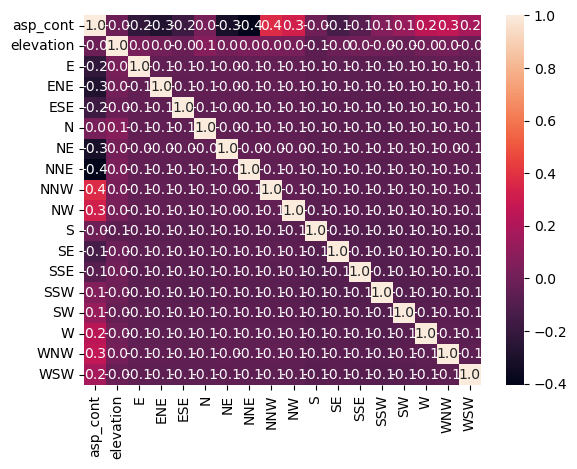

In [234]:
sns.heatmap(data=X.corr(),annot=True, fmt='.1f')

Additionally, there is no collinearity between aspect and elevation.

Areas in the mountains show more of a relationship, though this relationshpi is very small. This makes sense as areas in the mountains have steeper topography. In the city, where there is less elevation change, the aspect is more random or nonexistant.

## Modeling

### Train, Test, Split

Partition dataset to have $0.\overline3$ of the total as testing.

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X, y_array, test_size=(1/3),stratify=y)

#### Basic logistic regression:

##### `sklearn`:

In [244]:
# instantiate model
logreg=LogisticRegression()

# fit the model
logreg.fit(X_train,y_train)

print('Training Score: ',logreg.score(X_train,y_train))
print('Testing Score:  ',logreg.score(X_test,y_test))

Training Score:  0.8968176652053905
Testing Score:   0.8928397467121286


/Applications/Anaconda/anaconda3/envs/sklearn/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Good match with the training set, though the accuracy is lower than I'd like; it's nearly the same as the base rate. What about using `statsmodels` to see if we can make a stronger statistical understanding about what influences wildfires?

##### `statsmodels`:

In [245]:
# add constant to prepare for statsmodels

X_withconstant=sm.add_constant(X)
X_withconstant.head()

,const,asp_cont,elevation,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,1.0,31.883564,434.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1.0,7.624194,349.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,72.613029,288.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,335.170654,189.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,1.0,346.464142,229.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [246]:
# instantiate model
logreg_sm=sm.Logit(y,X_withconstant)

# fit the model
logreg_sm_results=logreg_sm.fit()

# summary
logreg_sm_results.summary()

         Current function value: 0.279820
         Iterations: 35


/Applications/Anaconda/anaconda3/envs/sklearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   fire   No. Observations:                18477
Model:                          Logit   Df Residuals:                    18459
Method:                           MLE   Df Model:                           17
Date:                Sat, 25 Mar 2023   Pseudo R-squ.:                  0.1934
Time:                        19:34:47   Log-Likelihood:                -5170.2
converged:                      False   LL-Null:                       -6409.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1251        nan        nan        nan         nan         nan
asp_cont      -0.0014      0.001     -2.164      0.030      -0.003      -0.000
elevation      0.0091      0.000     41.173      0.000       0.009       0.010
E             -0.2597        nan        nan        nan         nan         nan
ENE           -0.3258        nan        nan        nan         nan         nan
ESE           -0.3291        nan        nan        nan         nan         nan
N             -0.5536        nan        nan        nan         nan         nan
NE            -0.5103        nan        nan        nan         nan         nan
NNE           -0.4531        nan        nan        nan         nan         nan
NNW           -0.2887        nan        nan        nan         nan         nan
NW             0.1186        nan        nan        nan         nan         nan
S              0.4012        nan        nan        nan         nan         nan
SE             0.1400        nan        nan        nan         nan         nan
SSE            0.2898        nan        nan        nan         nan         nan
SSW            0.3094        nan        nan        nan         nan         nan
SW             0.4846        nan        nan        nan         nan         nan
W              0.3036        nan        nan        nan         nan         nan
WNW            0.1787        nan        nan        nan         nan         nan
WSW            0.6195        nan        nan        nan         nan         nan
==============================================================================
"""

In [247]:
results=logreg_sm_results.params

results

const        0.125106
asp_cont    -0.001377
elevation    0.009136
E           -0.259729
ENE         -0.325757
ESE         -0.329120
N           -0.553575
NE          -0.510301
NNE         -0.453130
NNW         -0.288700
NW           0.118586
S            0.401161
SE           0.140046
SSE          0.289772
SSW          0.309368
SW           0.484649
W            0.303638
WNW          0.178715
WSW          0.619453
dtype: float64

In [249]:
results_df=results(0)

results_df['beta_logOdds']=results_df[0]

results_df=results_df.drop(labels=[0],axis=1)

results_df

TypeError: 'Series' object is not callable

In [250]:
# sm_geo['asp_cat']=sm_geo['asp_cont'].apply(degToCompass)

results_df['beta_odds']=results_df['beta_odds'].apply(np.exp(results_df['beta_logOdds']))
results_df

KeyError: 'beta_odds'

Now let's try to increase the accuracy of our model.